# Data Clustering

1. Dataset: Google Review Ratings
2. Techniques Used: KMeans, DBSCAN, Spectral Clustering
3. Tools: Python, Pandas, NumPy, Scikit-learn, Matplotlib

Dataset Description : 

| Feature Count | 25 Columns                       |
| ------------- | -------------------------------- |
| Rows          | 5456 Users                       |
| Categories    | 24 Rating Categories (0–5 scale) |
| Type          | Numerical continuous values      |

In [1]:
import os
os.getcwd()
os.listdir()

['.ipynb_checkpoints', 'google_review_ratings.csv', 'Untitled.ipynb']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Data Preprocessing

Dataset = "google_review_ratings.csv"

| Step                     | Description                                              |
| ------------------------ | -------------------------------------------------------- |
| Removed Columns          | `User`, `Unnamed: 25` (not useful for clustering)        |
| Converted Types          | Applied `pd.to_numeric()` to ensure numeric format       |
| Missing Value Handling   | Filled missing values using column median                |
| Scaling                  | StandardScaler applied to normalize data (mean=0, std=1) |
| Dimensionality Reduction | PCA used for 2D visualization                            |

In [4]:
df = pd.read_csv("google_review_ratings.csv")
df.head()

# Drop the User column
df = df.drop(columns=["User"])

# Drop Unnamed column if it exists
if "Unnamed: 25" in df.columns:
    df = df.drop(columns=["Unnamed: 25"])

# Convert everything to numbers
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with median
df = df.fillna(df.median())

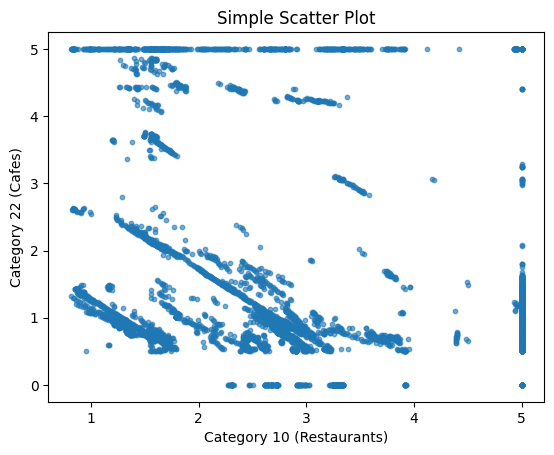

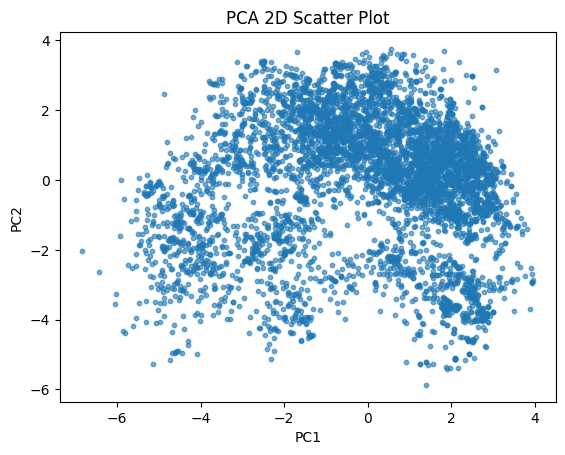

In [5]:
#Simle scatterplt the data
plt.scatter(df["Category 10"], df["Category 22"], s=10, alpha=0.6)
plt.xlabel("Category 10 (Restaurants)")
plt.ylabel("Category 22 (Cafes)")
plt.title("Simple Scatter Plot")
plt.show()

# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
# print(scaled[:5])

# PCA to 2 components
# for clustering the data we are PCA Scatterplot
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

# Scatter plot
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Scatter Plot")
plt.show()

## Experiment 1: KMeans Clustering

🔹 Elbow Method

Inertia was calculated for k=2 to k=10. A noticeable bend was visible around k=3, indicating an optimal cluster size.

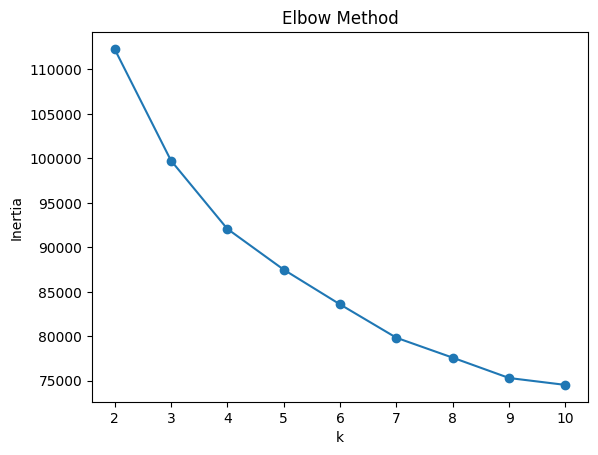

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_list = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled)
    inertia_list.append(model.inertia_)

plt.plot(K, inertia_list, "-o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

## KMeans Results

| Metric           | Value             |
| ---------------- | ----------------- |
| Best k           | **3**             |
| Silhouette Score | **~0.145**        |
| Clusters         | 3 Distinct Groups |

Cluster labels (first 15):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Silhouette Score: 0.14547617930817558


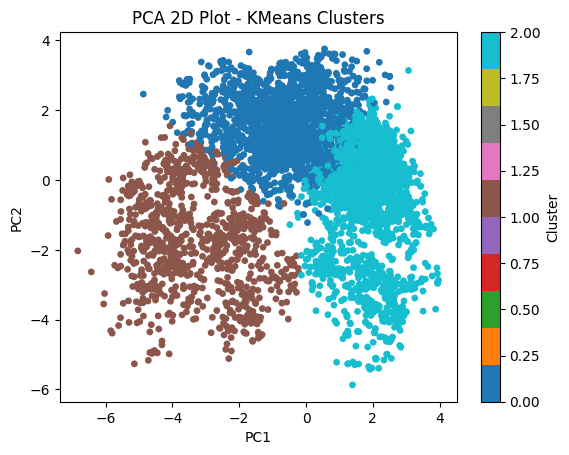

In [8]:
# ----------------------------------------------------
# Choose k (example: k=3 based on elbow)
# ----------------------------------------------------
k = 3
# ----------------------------------------------------
# Apply KMeans
# ----------------------------------------------------
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(scaled)


print("Cluster labels (first 15):")
print(labels[:15])

# ----------------------------------------------------
# Silhouette Score
# ----------------------------------------------------
sil_score = silhouette_score(scaled, labels)
print("Silhouette Score:", sil_score)

# ----------------------------------------------------
# PCA Scatter Plot with Cluster Colors
# ----------------------------------------------------
plt.scatter(pca_data[:,0], pca_data[:,1], c=labels, cmap='tab10', s=15)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Plot - KMeans Clusters")
plt.colorbar(label="Cluster")
plt.show()

## Experiment 2: DBSCAN

DBSCAN groups data based on density rather than fixed K

| Result             | Value                       |
| ------------------ | --------------------------- |
| Number of clusters | Many small density clusters |
| Noise detected     | Yes (`-1` values)           |
| Silhouette Score   | **~0.669** (very high)      |

In [9]:
from sklearn.cluster import DBSCAN

# -----------------------------------------
# Run DBSCAN
# -----------------------------------------
# Try with simple parameters and we can adjust later
# eps = 0.7
# min_samples = 5

dbscan = DBSCAN(eps=0.7, min_samples=5)
labels = dbscan.fit_predict(scaled)

print("Cluster labels (first 20):")
print(labels[:20])

# Count clusters
unique, counts = np.unique(labels, return_counts=True)
# print("\nCluster counts:")
# print(dict(zip(unique, counts)))

# Mask to exclude noise
mask = labels != -1

if len(set(labels[mask])) > 1:
    sil_score = silhouette_score(scaled[mask], labels[mask])
    print("Silhouette Score (excluding noise):", sil_score)
else:
    print("Not enough clusters for silhouette score.")


Cluster labels (first 20):
[ 0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Silhouette Score (excluding noise): 0.6699068545577814


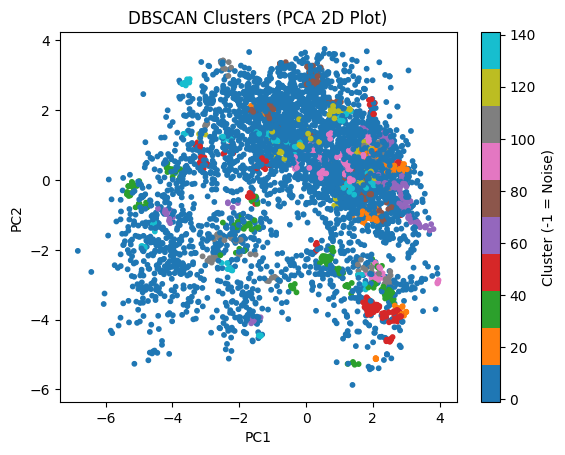

In [31]:
# -----------------------------------------
# Step 4: PCA 2D Scatter Plot for DB Scan
# -----------------------------------------
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)


plt.scatter(pca_data[:,0], pca_data[:,1], c=labels, cmap="tab10", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clusters (PCA 2D Plot)")
plt.colorbar(label="Cluster (-1 = Noise)")
plt.show()

## Experiment 3: Spectral Clustering

Used graph-based clustering with k=3 (same as KMeans for comparison).

In [10]:
from sklearn.cluster import SpectralClustering

# -----------------------------------------
# Apply Spectral Clustering
# -----------------------------------------
# Use 3 clusters to compare directly with KMeans
spectral = SpectralClustering(
    n_clusters=3,
    affinity='nearest_neighbors',   # works well for this dataset
    assign_labels='kmeans',
    random_state=42
)

labels = spectral.fit_predict(scaled)

print("Cluster labels (first 20):")
print(labels[:20])

# -----------------------------------------
# Step 4: Silhouette Score
# -----------------------------------------
sil_score = silhouette_score(scaled, labels)
print("Silhouette Score:", sil_score)

Cluster labels (first 20):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Silhouette Score: 0.09934605633580793


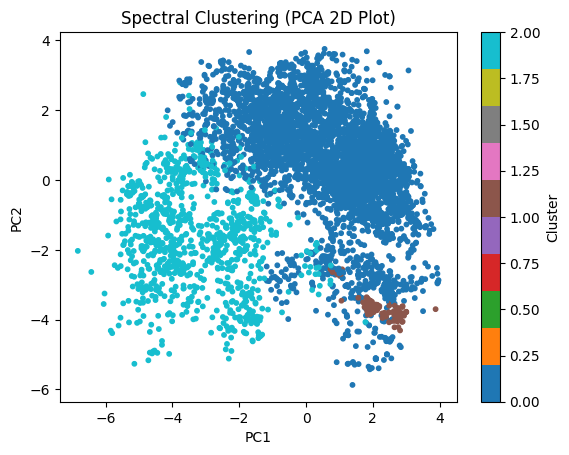

In [11]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

plt.scatter(pca_data[:,0], pca_data[:,1], c=labels, cmap="tab10", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Spectral Clustering (PCA 2D Plot)")
plt.colorbar(label="Cluster")
plt.show()